# Assignment 1: Heart Failure Classification Problem
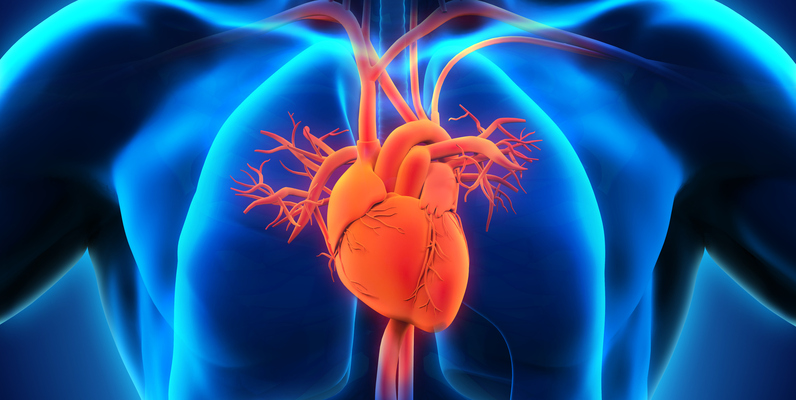

##### **Team Members**

- **Rawan Mohamed Said** - 21010547
- **Yomna Yasser Sobhy Zaki** - 21011566  
- **Omnia Tarek Ibrahim** - 21010298


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.neighbors import KNeighborsClassifier
#from google.colab import files
#files.upload()  # Upload the .py file manually


## **Helper Functions**

In [2]:
def plot_confusion_matrix(y_test, y_predict, color='Blues'):
  cm = confusion_matrix(y_test, y_predict)
  plt.figure(figsize=(5, 4))
  sns.heatmap(cm, annot=True, fmt='d', cmap=color)
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.title("Confusion Matrix")
  plt.show()

## **Dataset and Preparation**





After downloading the dataset, Read it from the .csv file and start getting familiar the dataset.

In [3]:
df = pd.read_csv("./heart.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
df.shape

(918, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


### Fixed Random Seed
Set the seed which is considered as an intial value for the pesudo random generator to get the same sequence of random values each time/run and ensure reproducibility across experiement.

In [6]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

### Feature Preprocessing:

In [7]:
# divide data into features and target/actual class
x = df.drop(['HeartDisease'], axis=1)
y = df["HeartDisease"]

#### Categorical Features Encoding

We need to convert categorical variables into numeric as many machine learning models can handle numeric variables only.
There are many ways to do that e.g. one-hot encoding and label encoding
the main differance between them that one-hot encoding adds column for each category and its values are zero or one.
For the label encoding it gives each category a value (0, 1, 2,...) in the same column and that could introduce problems. The model could thing that there are relation between these category like the category with value 1 is larger than value 0. In other words, It may introduce order for the categories so its better to use it when the data has natural order.


In [8]:
# get all categorical columns
categorical_cols = x.select_dtypes(include=['object']).columns.tolist()

# use OneHotEncoder to convert categorical variable into binary format
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(x[categorical_cols])
one_hot_x = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_cols))
x = pd.concat([x, one_hot_x], axis=1)
x = x.drop(categorical_cols, axis=1)

In [9]:
x.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,49,160,180,0,156,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,37,130,283,0,98,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,48,138,214,0,108,1.5,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,54,150,195,0,122,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


#### Data Scaling

We need to standardize or normalize the data.
  * Normalization => (x - min) / ( max - min)
  * Standardization => (x - mean) / sd

For our dataset, It's better to use **standardization** because of the outliers that our dataset has. Standardization ensures that the data is centered around 0 with a standard deviation of 1, and it is less sensitive to outliers compared to normalization.

**NOTE**: Scaling is important for distance-based algorithms such as **k Nearest Neighbors** because when the features have different scales:
* The algorithm prioritizes features with larger scales, even if those features are less relevant.
* Features on smaller scales contribute almost nothing to the distance metric, effectively making them irrelevant.

and it is also important for **Neural Network** to improve the stability of weight updates which helps the gradient decent converge faster.

However, **Decision Trees** are insensitive to the scale of the dataset because of its structure.

<Axes: >

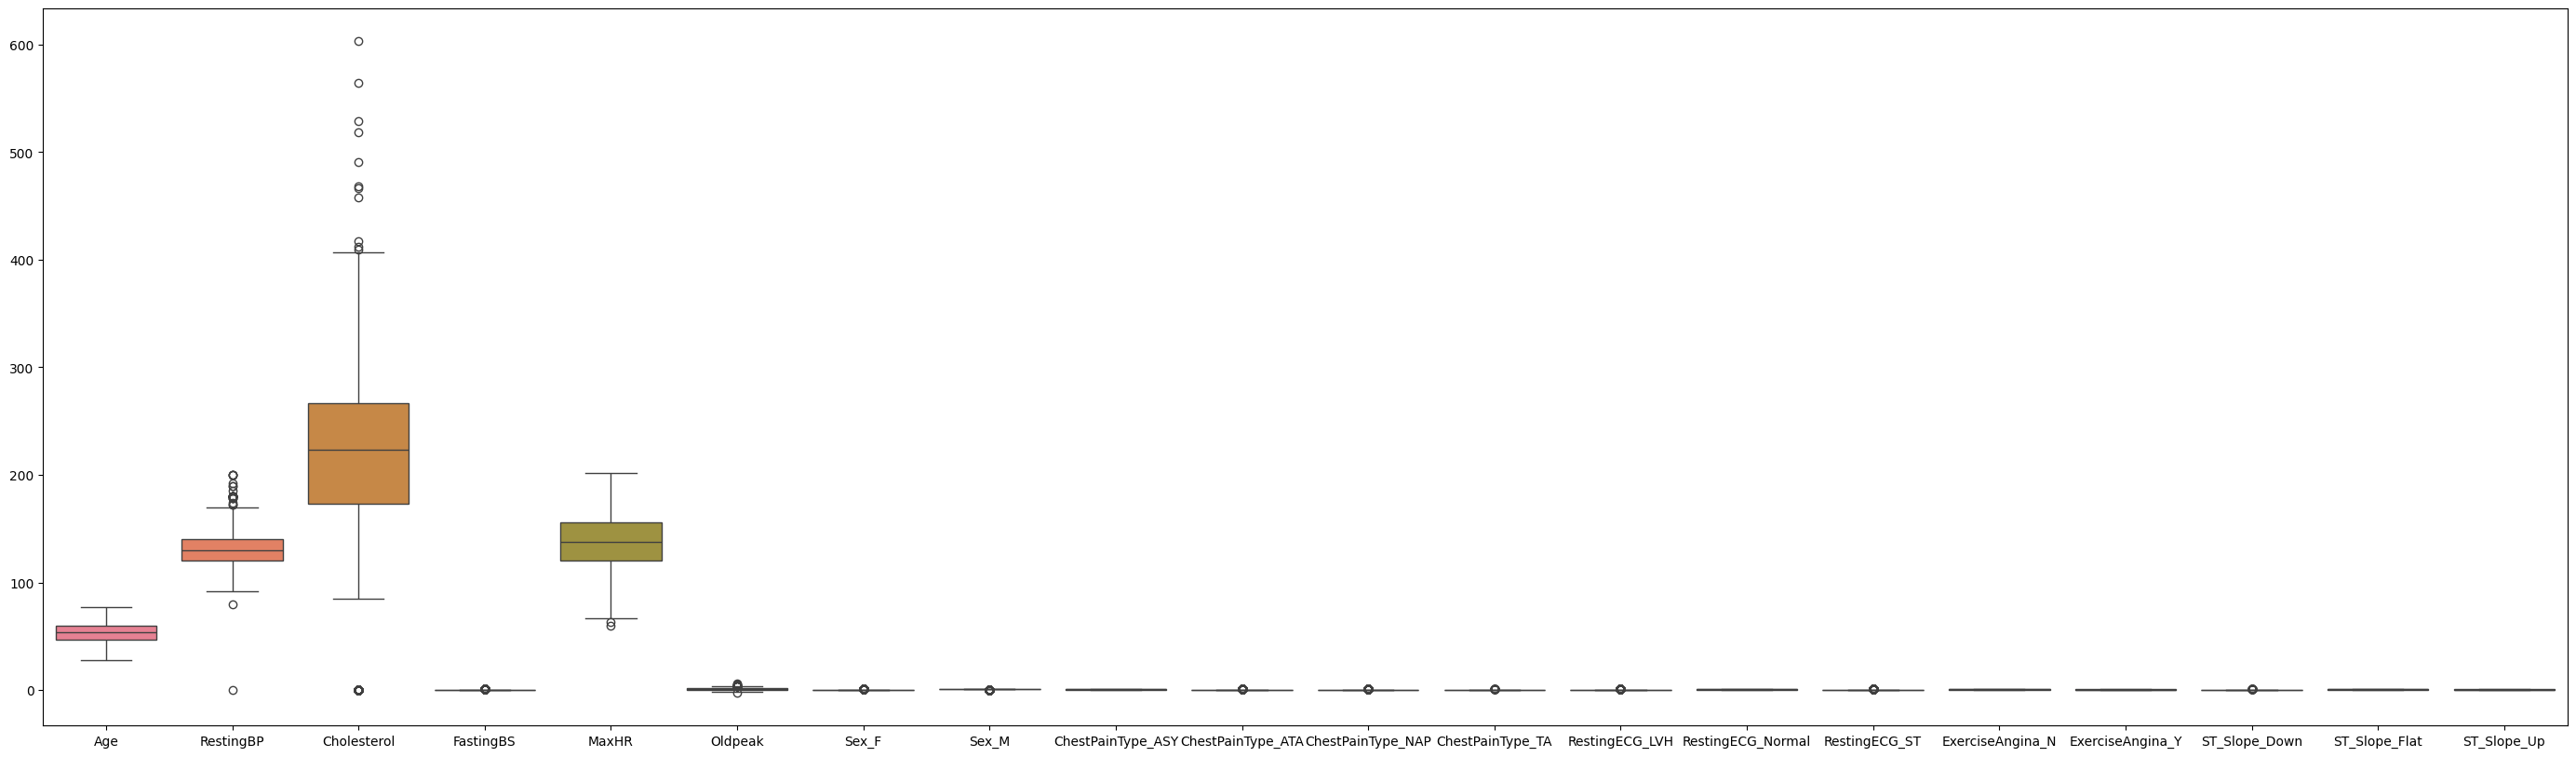

In [10]:
# use box plot to show the scales of each feature and observe the outliers.
plt.figure(figsize=(35,10))
sns.boxplot(data=x)

In [11]:
# apply standardization
scaler = StandardScaler()
scaled_x = scaler.fit_transform(x)
x = pd.DataFrame(scaled_x, columns=x.columns)

<Axes: >

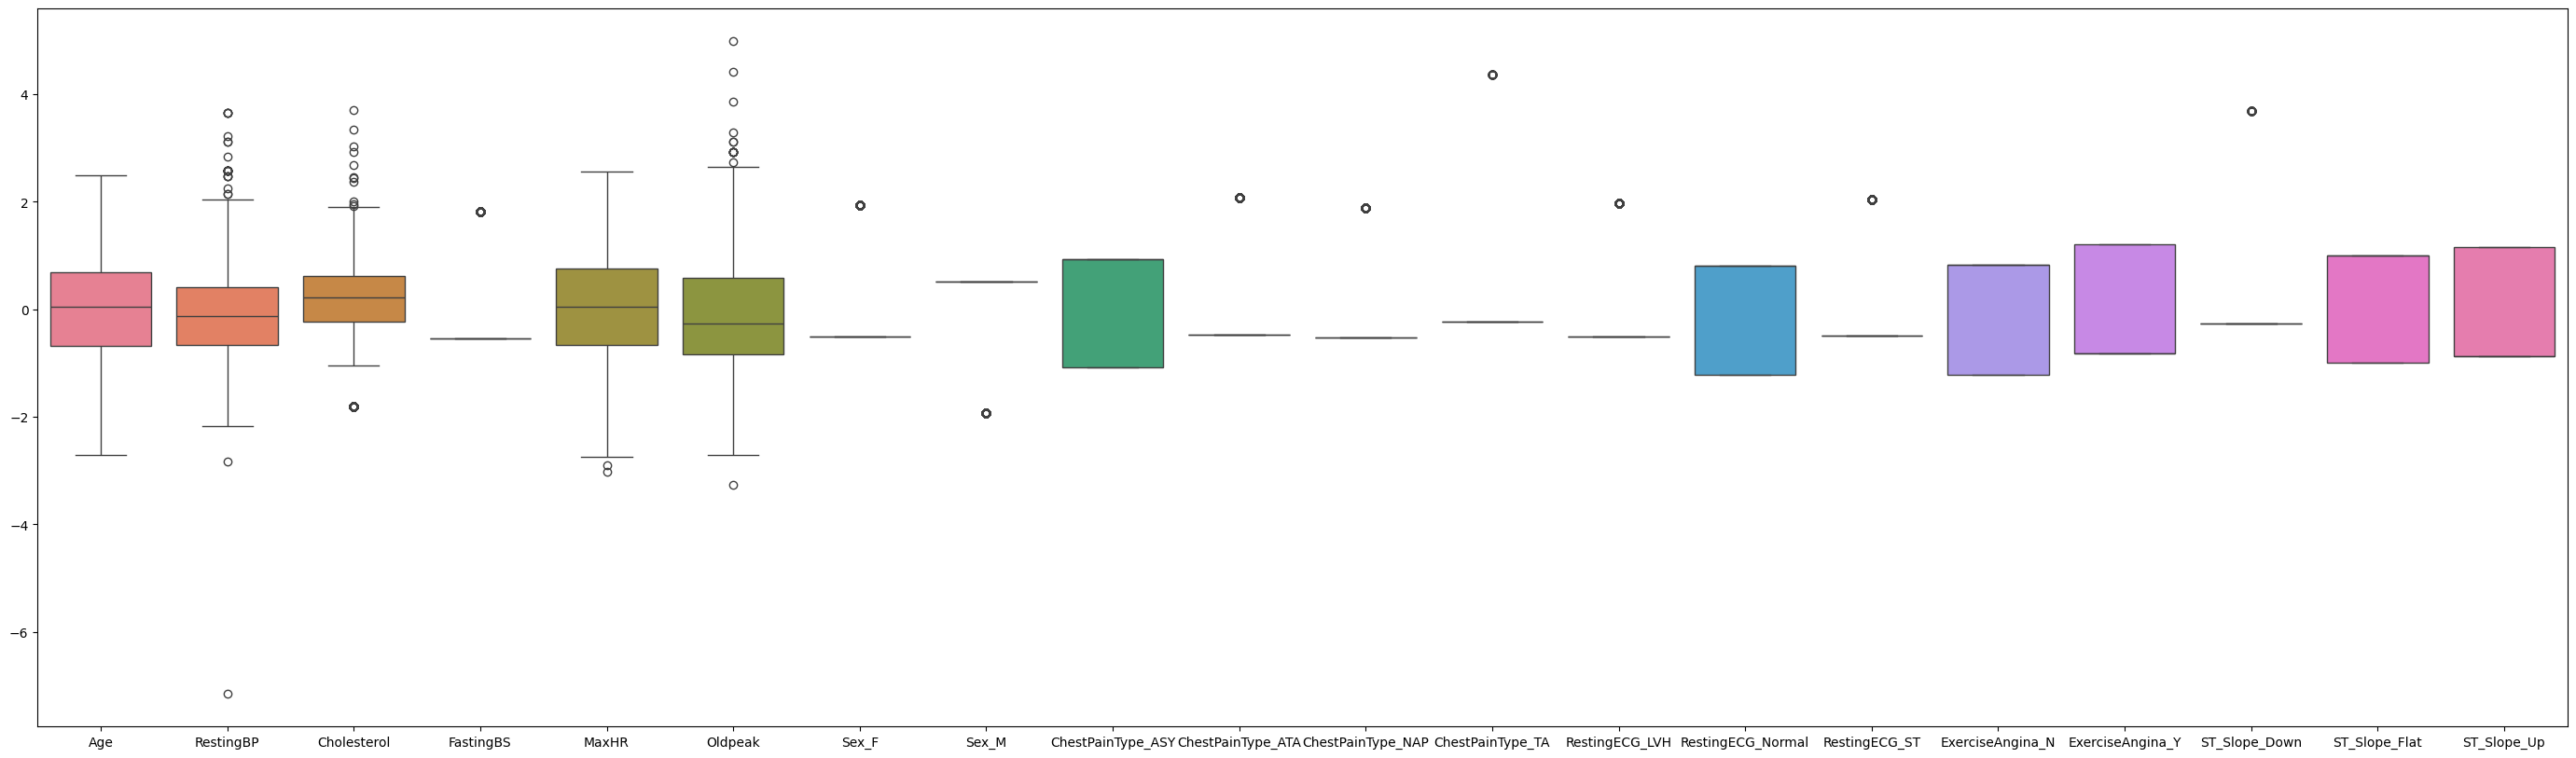

In [12]:
# use box plot after to show the effect of the standardization
plt.figure(figsize=(35,10))
sns.boxplot(data=x)

### Train/Validation/Test Split

Splitting the data into train, validation and test sets and use stratify to ensure that the propotion of each class is same as its propotion in the original dataset.

In [13]:
# split data into train_validation and test where the size of the test = 0.2
x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, random_state=RANDOM_SEED, test_size=0.2, stratify=y)

# split train_validation into train and validation where the size of the validation = 1/8 = 0.125
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, random_state=RANDOM_SEED, test_size = 0.125, stratify=y_train_val)

In [14]:
print(f"Train size: {x_train.shape[0]}, Validation size: {x_val.shape[0]}, Test size: {x_test.shape[0]}")

Train size: 642, Validation size: 92, Test size: 184


## Decision Tree

In [15]:
import numpy as np
import pandas as pd
from itertools import product
from sklearn.metrics import accuracy_score

class DecisionTree:
    def __init__(self, max_depth=20, min_samples_split=2):
        self.max_depth = max_depth                  # Maximum depth of the tree can be reached
        self.min_samples_split = min_samples_split  # Least number of samples required to split a node
        self.tree = None

    def fit(self, X, y, sample_weights=None):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        # Calculating the weights if not provided
        if sample_weights is None:
            # each sample has a weight of 1/n_samples
            sample_weights = np.ones(len(y)) / len(y)
        else:
            sample_weights = sample_weights / np.sum(sample_weights)
        # Constructing the tree
        self.tree = self._grow_tree(X, y, sample_weights, depth=0)

    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        return np.array([self._traverse_tree(sample, self.tree) for sample in X])

    def auto_tune(self, X_train, y_train, X_val, y_val):
        # Building the deepest tree
        self.max_depth = 20
        self.fit(X_train, y_train)

        best_depth, best_min_samples = 1, 2
        best_acc = 0

        # Finding the best parameters
        for depth, min_samples in product(range(1, 21), range(2, 21)):
            self.max_depth = depth
            self.min_samples_split = min_samples

            preds = self.predict(X_val)
            acc = accuracy_score(y_val, preds)

            if acc > best_acc:
                best_acc = acc
                best_depth = depth
                best_min_samples = min_samples

        self.max_depth = best_depth
        self.min_samples_split = best_min_samples

        print(f"Best parameters: max_depth={self.max_depth}, min_samples_split={self.min_samples_split}")

    def _grow_tree(self, X, y, sample_weights, depth):
        n_samples = X.shape[0]

        # Stopping criteria
        # If the depth limit is reached or the number of samples is less than the minimum required for
        #  a split or all the samples have the same label then create a leaf node
        if depth >= self.max_depth or n_samples < self.min_samples_split or len(set(y)) == 1:
            return self._create_leaf(y, sample_weights)

        # Finding the best split
        best_feature, best_threshold = self._best_split(X, y, sample_weights)
        # If no split is found, create a leaf node
        if best_feature is None:
            return self._create_leaf(y, sample_weights)

        # Split the dataset
        left_idx = X[:, best_feature] <= best_threshold
        right_idx = ~left_idx

        classification = self._create_leaf(y, sample_weights)

        left = self._grow_tree(X[left_idx], y[left_idx], sample_weights[left_idx], depth + 1)
        right = self._grow_tree(X[right_idx], y[right_idx], sample_weights[right_idx], depth + 1)

        return {"feature": best_feature, "threshold": best_threshold, "samples": n_samples, "class": classification["leaf"], "left": left, "right": right}

    def _create_leaf(self, y, sample_weights):
        # Create a leaf node
        # The leaf node will contain the most common label in the samples
        class_counts = {}
        for label in np.unique(y):
            class_counts[label] = np.sum(sample_weights[np.where(y == label)])

        return {"leaf": max(class_counts, key=class_counts.get), "error": class_counts[min(class_counts, key=class_counts.get)]}

    def _best_split(self, X, y, sample_weights):
        best_gain = -1
        best_feature = None
        best_threshold = None

        # Looping through all the features and their unique values to find the best split
        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                gain = self._information_gain(X, y, sample_weights, feature, threshold)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def _information_gain(self, X, y, sample_weights, feature, threshold):
        parent_entropy = self._entropy(y, sample_weights)
        # Splitting the dataset
        # left_idx contains the indices of the samples that are less than or equal to the threshold
        # and right_idx contains the indices of the samples that are greater than the threshold
        left_idx = X[:, feature] <= threshold
        right_idx = ~left_idx

        # If all the samples are in one side of the split, then the split is not valid
        if np.sum(left_idx) == 0 or np.sum(right_idx) == 0:
            return 0

        # Calculating the entropy of the left and right nodes
        left_entropy = self._entropy(y[left_idx], sample_weights[left_idx])
        right_entropy = self._entropy(y[right_idx], sample_weights[right_idx])

        # Calculating the weight of the left and right nodes
        left_weight = np.sum(sample_weights[left_idx])
        right_weight = np.sum(sample_weights[right_idx])

        return parent_entropy - (left_weight * left_entropy + right_weight * right_entropy)

    def _entropy(self, y, sample_weights):
        class_counts = {}
        # Calculating the weighted counts of the classes
        for label in np.unique(y):
            class_counts[label] = np.sum(sample_weights[np.where(y == label)])

        entropy = 0
        for label in class_counts:
            prob = class_counts[label]
            if prob > 0:
                entropy -= prob * np.log2(prob)
        return entropy

    def _traverse_tree(self, sample, node, current_depth=0):
        if "leaf" in node or current_depth >= self.max_depth or node.get("samples", float("inf")) < self.min_samples_split:
            if "leaf" not in node:
                return node["class"]
            return node["leaf"]
        if sample[node["feature"]] <= node["threshold"]:
            return self._traverse_tree(sample, node["left"], current_depth + 1)
        return self._traverse_tree(sample, node["right"], current_depth + 1)

In [16]:
# Training and validating the model to tune the parameters (max depth and min samples split)
tree = DecisionTree()
tree.auto_tune(x_train, y_train, x_val, y_val)
tree.fit(x_train, y_train)

Best parameters: max_depth=6, min_samples_split=11


In [17]:
# Validation accuracy
dec_y_val_pred = tree.predict(x_val)
dec_val_accuracy = accuracy_score(y_val, dec_y_val_pred)
print(f"Validation Accuracy: {dec_val_accuracy:.4f}")

Validation Accuracy: 0.8261


### Evaluation

In [18]:
# Testing the model
dec_y_test_pred = tree.predict(x_test)
dec_test_accuracy = accuracy_score(y_test, dec_y_test_pred)
dec_test_f1 = f1_score(y_test, dec_y_test_pred, average="weighted")

print(classification_report(y_test, dec_y_test_pred))

              precision    recall  f1-score   support

           0       0.73      0.78      0.75        82
           1       0.81      0.76      0.79       102

    accuracy                           0.77       184
   macro avg       0.77      0.77      0.77       184
weighted avg       0.77      0.77      0.77       184



In [19]:
results_df = pd.DataFrame({
    "Model": ["Decision Tree"],
    "   Validation Accuracy": [dec_val_accuracy],
    "   Test Accuracy": [dec_test_accuracy],
    "   Test F1-Score": [dec_test_f1]
})
print("Performance Summary:\n", results_df)

Performance Summary:
            Model     Validation Accuracy     Test Accuracy     Test F1-Score
0  Decision Tree                0.826087          0.771739          0.772309


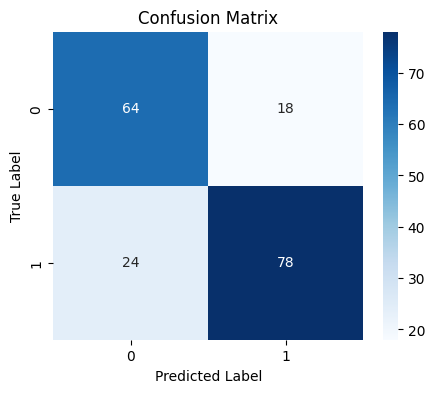

In [20]:
# Confusion Matrix
plot_confusion_matrix(y_test, dec_y_test_pred)

In [21]:
# Finding the Most Confusing Classes
cm = confusion_matrix(y_test, dec_y_test_pred)
np.fill_diagonal(cm, 0)
most_confused_idx = np.unravel_index(np.argmax(cm), cm.shape)
print(f"Most Confused Class -> Predicted = {most_confused_idx[1]}, True = {most_confused_idx[0]} with {cm[most_confused_idx]} misclassifications")

Most Confused Class -> Predicted = 0, True = 1 with 24 misclassifications


## Bagging Ensemble

In [22]:
class BaggingClassifier:
  def __init__(self, base_classifier, n_classifiers = 10):
    self.base_classifier = base_classifier
    self.n_classifiers = n_classifiers
    self.classifiers = []

  def fit(self, x_train, y_train, x_val, y_val):
    for _ in range(self.n_classifiers):
      # create bootstrap sampling with replacement
      sample_size = x_train.shape[0]
      indices = np.random.choice(sample_size, sample_size, replace = True)
      x_train_sampled = x_train.iloc[indices]
      y_train_sampled = y_train.iloc[indices]

      # create a new classifier and train it
      classifier = self.base_classifier.__class__()
      classifier.auto_tune(x_train_sampled, y_train_sampled, x_val, y_val)
      classifier.fit(x_train_sampled, y_train_sampled)
      self.classifiers.append(classifier)

  def predict(self, x_test):
    predictions = []
    # get the prediction from each classifier
    for classifier in self.classifiers:
      predictions.append(classifier.predict(x_test))

    # get the majority prediction over all classifiers
    majority_votes = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)
    return majority_votes



Tuning Bagging classifier to find best number of classifiers

In [23]:
best_n_classifiers = 1
best_accuracy = 0
best_classifier = None
DT = DecisionTree()
for n in range(10, 50, 10):
  # train the model
  bagging = BaggingClassifier(base_classifier = DT, n_classifiers = n)
  bagging.fit(x_train, y_train, x_val, y_val)

  y_predict = bagging.predict(x_val)
  val_accuracy = accuracy_score(y_val, y_predict)

  if val_accuracy > best_accuracy :
    best_accuracy = val_accuracy
    best_n_classifiers = n
    best_classifer = bagging

print(f"\nBest number of classifiers = {best_n_classifiers} with validation accuracy: {best_accuracy:.4f}")

Best parameters: max_depth=5, min_samples_split=2
Best parameters: max_depth=6, min_samples_split=2
Best parameters: max_depth=4, min_samples_split=2
Best parameters: max_depth=4, min_samples_split=2
Best parameters: max_depth=4, min_samples_split=2
Best parameters: max_depth=1, min_samples_split=2
Best parameters: max_depth=5, min_samples_split=2
Best parameters: max_depth=4, min_samples_split=2
Best parameters: max_depth=3, min_samples_split=2
Best parameters: max_depth=1, min_samples_split=2
Best parameters: max_depth=5, min_samples_split=16
Best parameters: max_depth=7, min_samples_split=2
Best parameters: max_depth=8, min_samples_split=6
Best parameters: max_depth=4, min_samples_split=2
Best parameters: max_depth=7, min_samples_split=15
Best parameters: max_depth=3, min_samples_split=2
Best parameters: max_depth=8, min_samples_split=8
Best parameters: max_depth=6, min_samples_split=2
Best parameters: max_depth=3, min_samples_split=2
Best parameters: max_depth=5, min_samples_split=

In [24]:
# Testing the model
y_predict = bagging.predict(x_test)
test_accuracy = accuracy_score(y_test, y_predict)
test_f1 = f1_score(y_test, y_predict, average="weighted")

print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.79      0.74      0.77        82
           1       0.80      0.84      0.82       102

    accuracy                           0.80       184
   macro avg       0.80      0.79      0.80       184
weighted avg       0.80      0.80      0.80       184



In [25]:
results_df = pd.DataFrame({
    "Model": ["Bagging Classifier"],
    "   Test Accuracy": [test_accuracy],
    "   Test F1-Score": [test_f1]
})
print("Performance Summary:\n", results_df)

Performance Summary:
                 Model     Test Accuracy     Test F1-Score
0  Bagging Classifier          0.798913          0.798157


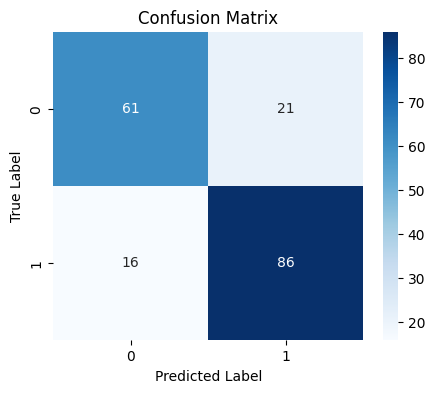

In [26]:
plot_confusion_matrix(y_test, y_predict)

## Ada Boost Ensemble

In [27]:
## This function is to find best split
def find_best_split(X, y, sample_weights):
    n_samples, n_features = X.shape
    best_feature_index, best_threshold, best_error, best_less_or_equal_classification = None, None, float('inf'), None

    for feature_index in range(n_features):
        unique_values = np.unique(X[:, feature_index]) # get unique values
        thresholds = (unique_values[:-1] + unique_values[1:]) / 2  # Compute midpoints which helps in case of continuous values

        for threshold in thresholds:
            # Compute weight sums for each class split
            X = np.array(X)
            y = np.array(y)
            sample_weights = np.array(sample_weights)
            # Compute weight sums for each class split
            left_weights_positive = np.sum(sample_weights[(X[:, feature_index] <= threshold) & (y == 1)])     # for left samples with positive label
            left_weights_negative = np.sum(sample_weights[(X[:, feature_index] <= threshold) & (y == -1)])    # for left samples with negative label
            right_weights_positive = np.sum(sample_weights[(X[:, feature_index] > threshold) & (y == 1)])     # for right samples with positive label
            right_weights_negative = np.sum(sample_weights[(X[:, feature_index] > threshold) & (y == -1)])    # for right samples with negative label

            # Determine best class assignment
            if (left_weights_negative + right_weights_positive) <= (left_weights_positive + right_weights_negative):
                split_best_less_or_equal_classification = 1
                misclassified_weight = left_weights_negative + right_weights_positive
            else:
                split_best_less_or_equal_classification = -1
                misclassified_weight = left_weights_positive + right_weights_negative

            # Update best split if found a lower error
            if misclassified_weight < best_error:
                best_feature_index = feature_index
                best_threshold = threshold
                best_error = misclassified_weight
                best_less_or_equal_classification = split_best_less_or_equal_classification

    return best_feature_index, best_threshold, best_error, best_less_or_equal_classification

In [28]:
# calculating the new alpha (classifier coefficient)
def calculate_alpha(error):
    return 0.5 * np.log((1 - error) / error)

In [29]:
# calculating new weights for each sample
def calculate_new_weights(weights, error, is_right_classified):
    new_weights = []

    for i in range(len(is_right_classified)):
        if is_right_classified[i] == 1:
            new_weights.append((0.5 * weights[i]) / (1 - error))
        else:
            new_weights.append((0.5 * weights[i]) / error)
    return new_weights

In [30]:
# AdaBoost Classifier
class AdaBoostClassifier:
    def __init__(self, n_estimators=50):
        self.n_estimators = n_estimators
        self.models = []
    def fit(self, X, y_binary):
        n_samples, n_features = X.shape
        weights = np.full(n_samples, 1 / n_samples)
       ## iam just using another column y
        y_converted = np.where(y_binary == 0, -1, 1) ## it is faster than looping as it is vectorized
        for _ in range(self.n_estimators):
            feature_index, threshold, error, less_or_equal_classification = find_best_split(X, y_converted, weights)
            is_right_classified = np.where(((X[:, feature_index] <= threshold) & (y_converted == less_or_equal_classification)) |
                      ((X[:, feature_index] > threshold) & (y_converted == -less_or_equal_classification)), 1, -1)
            error = max(error, 1e-10) # to avoid divisions by zero
            weights = calculate_new_weights(weights, error, is_right_classified)
            alpha = calculate_alpha(error)
            model = (feature_index, threshold, alpha, less_or_equal_classification)
            self.models.append(model)

   # for predicting a set of samples
    def predict(self, X):
        n_samples = X.shape[0]
        y_pred = np.zeros(n_samples)  # Initialize predictions to zero
        for feature_index, threshold, alpha, less_or_equal_classification in self.models:
            # Create predictions for this weak learner for all X sample i gave to it
            y_pred_i = np.where(X[:, feature_index] <= threshold, less_or_equal_classification, -less_or_equal_classification)
            # Accumulate the weighted predictions
            y_pred += alpha * y_pred_i
        return np.where(np.sign(y_pred) == -1, 0, 1)  # Final prediction: sign of weighted sum


Tuning


In [31]:
n_iterations = range(10, 101, 10)
best_n_iterations = None
best_accuracy = 0
validation_accuracies = []
best_ada = None
for n in n_iterations:
    ada  = AdaBoostClassifier(n_estimators=n)
    ada.fit(x_train.to_numpy(), y_train.to_numpy())

    ## Validate model and get its accuracy
    y_val_pred = ada.predict(x_val.to_numpy())
    right_classified = np.sum(y_val_pred == y_val)  # Count rightclassified samples
    accuracy = right_classified / len(y_val)# to get the accuraccy rate
    validation_accuracies.append(accuracy)
    ## make it the best accuracy if better than before
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_n_iterations = n
        best_ada = ada

print(f"\nBest n_estimators = {best_n_iterations} with validation accuracy: {best_accuracy:.4f}")


Best n_estimators = 20 with validation accuracy: 0.8478


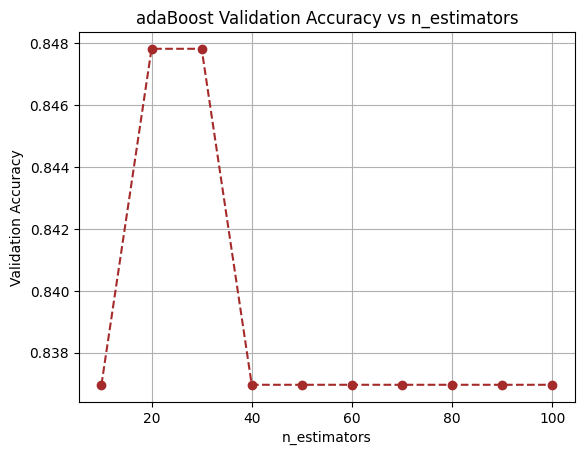

In [32]:
#plotting the validation accuracy at different values of n_estimators
plt.plot(n_iterations, validation_accuracies, marker='o', linestyle='dashed', color='brown')
plt.xlabel("n_estimators")
plt.ylabel("Validation Accuracy")
plt.title("adaBoost Validation Accuracy vs n_estimators")
plt.grid()
plt.show()


Evaluation


AdaBoost: Test Accuracy: = 0.891
AdaBoost: F1 Score: = 0.901
AdaBoost: Confusion Matrix:
 [[73  9]
 [11 91]]


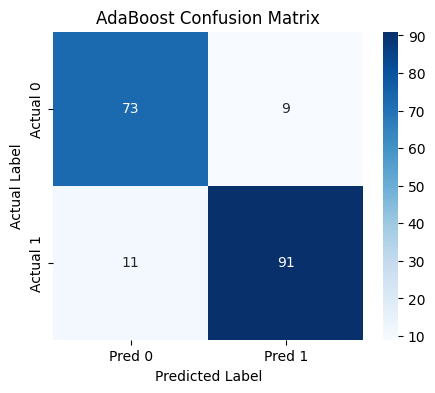

In [33]:
y_predict = best_ada.predict(x_test.to_numpy())
right_classified = np.sum(y_predict == y_test)  # Count misclassified samples

test_accuracy = right_classified / len(y_test)  # to get the accuraccy rate
f_score = f1_score(y_test.to_numpy(), y_predict)
conf_matrix = confusion_matrix(y_test.to_numpy(), y_predict)

print(f"AdaBoost: Test Accuracy: = {test_accuracy:.3f}")
print(f"AdaBoost: F1 Score: = {f_score:.3f}")
print(f"AdaBoost: Confusion Matrix:\n {conf_matrix}")

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred 0", "Pred 1"], yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("AdaBoost Confusion Matrix")
plt.show()

## **Bonus**

### K-Nearest Neighbors


In [34]:
# tune for k from 1 to 20
k_values = range(1, 21)
best_k = None
best_accuracy = 0
validation_accuracies = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train.to_numpy(), y_train.to_numpy())
    ## Validate model and get its accuracy
    y_val_pred = knn.predict(x_val.to_numpy())
    accuracy = accuracy_score(y_val, y_val_pred)
    validation_accuracies.append(accuracy)
    #print(f"k={k}, Validation Accuracy: {accuracy:.4f}")
    ## make it the best accuracy if better than before
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k

print(f"\nBest k = {best_k} with validation accuracy: {validation_accuracies[best_k - 1]:.4f}")


Best k = 3 with validation accuracy: 0.8261


In [35]:
# Train the best model and evaluate on test set
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(x_train, y_train)

y_test_pred = knn_best.predict(x_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Test Accuracy with k = {best_k}: {test_accuracy:.4f}")

Test Accuracy with k = 3: 0.8750


In [36]:
print("Classification Report: \n", classification_report(y_test, y_test_pred))

Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.82      0.85        82
           1       0.86      0.92      0.89       102

    accuracy                           0.88       184
   macro avg       0.88      0.87      0.87       184
weighted avg       0.88      0.88      0.87       184



KNN Accuracy is 0.875


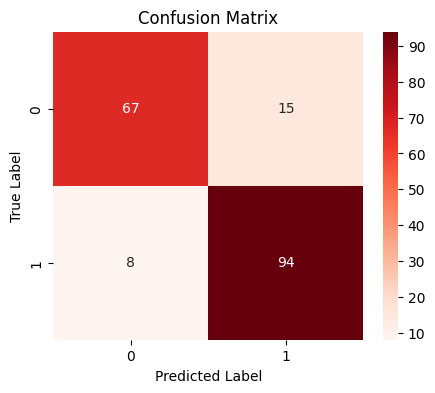

In [37]:
accuracy = accuracy_score(y_test, y_test_pred)
print( f'KNN Accuracy is {accuracy}')

plot_confusion_matrix(y_test, y_test_pred, "Reds")

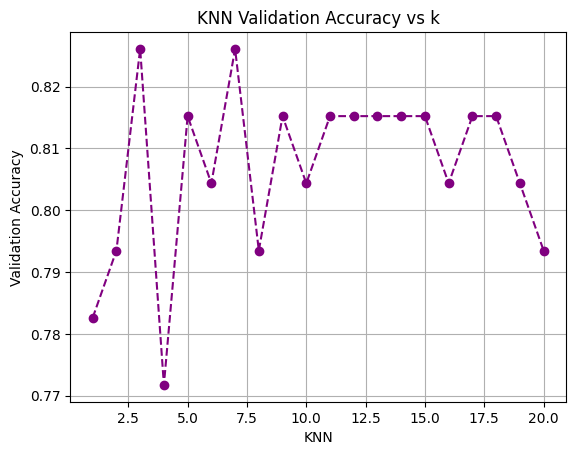

In [38]:
#plotting the validation accuracy at different values of k
plt.plot(k_values, validation_accuracies, marker='o', linestyle='dashed', color='purple')
plt.xlabel("KNN")
plt.ylabel("Validation Accuracy")
plt.title("KNN Validation Accuracy vs k")
plt.grid()
plt.show()


### Logistic Regression

In [39]:
logistic_model= LogisticRegression(random_state = RANDOM_SEED, max_iter = 100)
logistic_model.fit(x_train_val,y_train_val)


LogisticRegression(random_state=42)

In [40]:
y_test_pred = logistic_model.predict(x_test)


Logistic Regression Accuracy is 0.8858695652173914


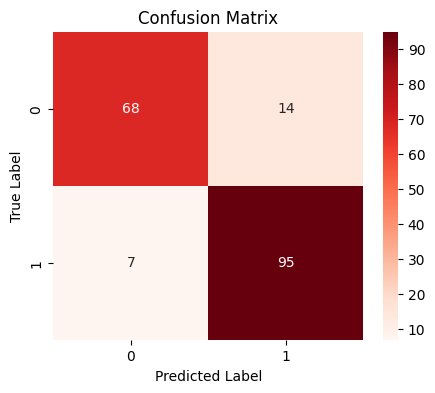

In [41]:
accuracy = accuracy_score(y_test, y_test_pred)
print( f'Logistic Regression Accuracy is {accuracy}')

plot_confusion_matrix(y_test, y_test_pred, "Reds")

We need to tune the parameter C in logistic regression which is the inverse of the regularization strength. It controls how much penalty is applied to the model's coefficients to prevent overfitting.

In [42]:
from sklearn.model_selection import GridSearchCV
# Tune regularization parameter C
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(LogisticRegression(max_iter=1000, random_state=RANDOM_SEED), param_grid, cv=5)
grid_search.fit(x_train, y_train)

# Best model and its performance
best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(x_val)

print("Best regularization parameter C:", grid_search.best_params_['C'])
print("Accuracy with tuned parameters:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

Best regularization parameter C: 0.01
Accuracy with tuned parameters: 0.7934782608695652

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.80      0.78        41
           1       0.83      0.78      0.81        51

    accuracy                           0.79        92
   macro avg       0.79      0.79      0.79        92
weighted avg       0.80      0.79      0.79        92



### Feedforward Neural Network (FNN)

In [81]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

tf.random.set_seed(RANDOM_SEED)

In [82]:
# Making a Simple Feedforward Neural Network
model = Sequential([
    Input(shape=(x_train.shape[1],)),           # Input layer with shape of the input data
    Dense(32, activation='relu'),               # Hidden layer with 32 neurons with ReLU activation
    Dense(1, activation='sigmoid')              # Output layer (Binary Classification) with Sigmoid activation
])

model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [83]:
# Training the model with 50 epochs and batch size of 16
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, batch_size=16, verbose=1)

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7684 - loss: 0.4690 - val_accuracy: 0.8043 - val_loss: 0.4126
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8829 - loss: 0.2905 - val_accuracy: 0.8152 - val_loss: 0.3787
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8804 - loss: 0.2713 - val_accuracy: 0.8370 - val_loss: 0.3764
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8881 - loss: 0.2620 - val_accuracy: 0.8370 - val_loss: 0.3731
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8927 - loss: 0.2546 - val_accuracy: 0.8587 - val_loss: 0.3736
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8934 - loss: 0.2480 - val_accuracy: 0.8587 - val_loss: 0.3683
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8985 - loss: 0.2443 - val_accuracy: 0.8587 - val_loss: 0.3702
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8942 - loss: 0.2409 - val_accuracy: 0.8587 - val_loss:

In [84]:
# Evaluating the model on the test set
fnn_test_loss, fnn_test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {fnn_test_accuracy:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8620 - loss: 0.7690 
Test Accuracy: 0.8587


In [85]:
fnn_y_test_pred = (model.predict(x_test) > 0.5).astype(int) # Convert probabilities to binary predictions
print("Classification Report:\n", classification_report(y_test, fnn_y_test_pred))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.85      0.84        82
           1       0.88      0.86      0.87       102

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184



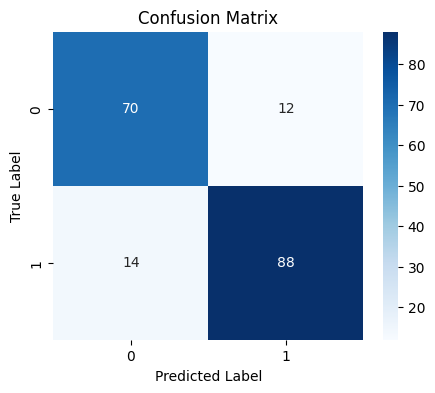

In [86]:
plot_confusion_matrix(y_test, fnn_y_test_pred)